## Medición de Riesgos: Práctica 2

Autor: Guillem Borràs Espert

Fecha: 08/01/2026

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm

from statsmodels.regression.quantile_regression import QuantReg
from utils import descriptive_stats, caviar_asymmetric, parametric_var_gjr, clean_desc, obtener_estadisticas

- Pregunta 2

In [3]:
tickers = {
    "Lloyds Banking Group": "LLOY.L",
    "Prudential plc": "PRU.L",
    "Fortum": "FORTUM.HE",
    "Sopra Steria": "SOP.PA",
    "STOXX600": "^STOXX"
}

start_date = "2015-01-01"
end_date = "2025-10-31"

In [4]:
raw_data = yf.download(
    list(tickers.values()),
    start=start_date,
    end=end_date,
    progress=False
)

prices = raw_data["Close"]

prices.columns = tickers.keys()

In [5]:
log_returns = np.log(prices / prices.shift(1)).dropna()

assets = [
    "Lloyds Banking Group",
    "Prudential plc",
    "Fortum",
    "Sopra Steria"
]
weights = np.repeat(1 / len(assets), len(assets))

log_returns["POR"] = log_returns[assets].dot(weights)

In [6]:
rf_annual = 0.025
rf_daily = rf_annual / 252

In [7]:
series_for_analysis = assets + ["POR", "STOXX600"]
stats_table = descriptive_stats(log_returns[series_for_analysis], rf_daily)


print("\nTABLA DE ESTADÍSTICOS DESCRIPTIVOS\n")
display(stats_table.round(4))


TABLA DE ESTADÍSTICOS DESCRIPTIVOS



,Media anual,Volatilidad anual,Asimetría,Curtosis,Sharpe Ratio
Lloyds Banking Group,0.0785,0.2898,-0.7127,6.8076,0.1848
Prudential plc,0.0506,0.2927,-0.0243,7.1250,0.0873
Fortum,0.0380,0.3293,-0.1527,8.1430,0.0395
Sopra Steria,0.1195,0.3444,-0.8009,20.1853,0.2745
POR,0.0717,0.2311,-0.6896,8.6342,0.2019
STOXX600,0.0730,0.1620,-1.0431,13.2421,0.2964


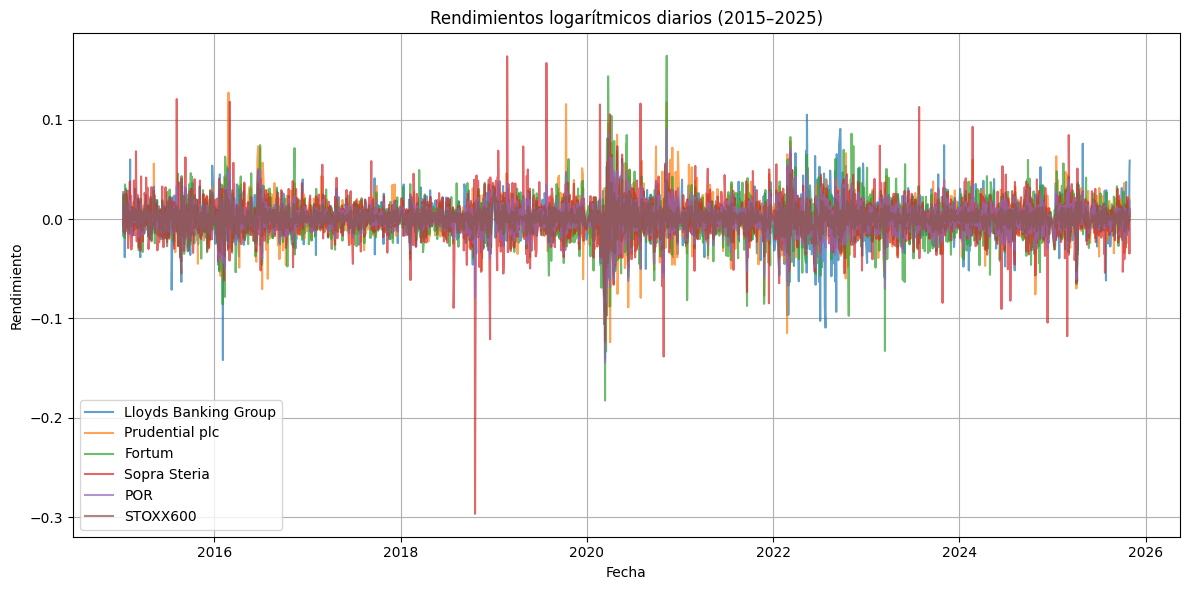

In [8]:
plt.figure(figsize=(12, 6))

for col in series_for_analysis:
    plt.plot(log_returns.index, log_returns[col], label=col, alpha=0.7)

plt.title("Rendimientos logarítmicos diarios (2015–2025)")
plt.xlabel("Fecha")
plt.ylabel("Rendimiento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

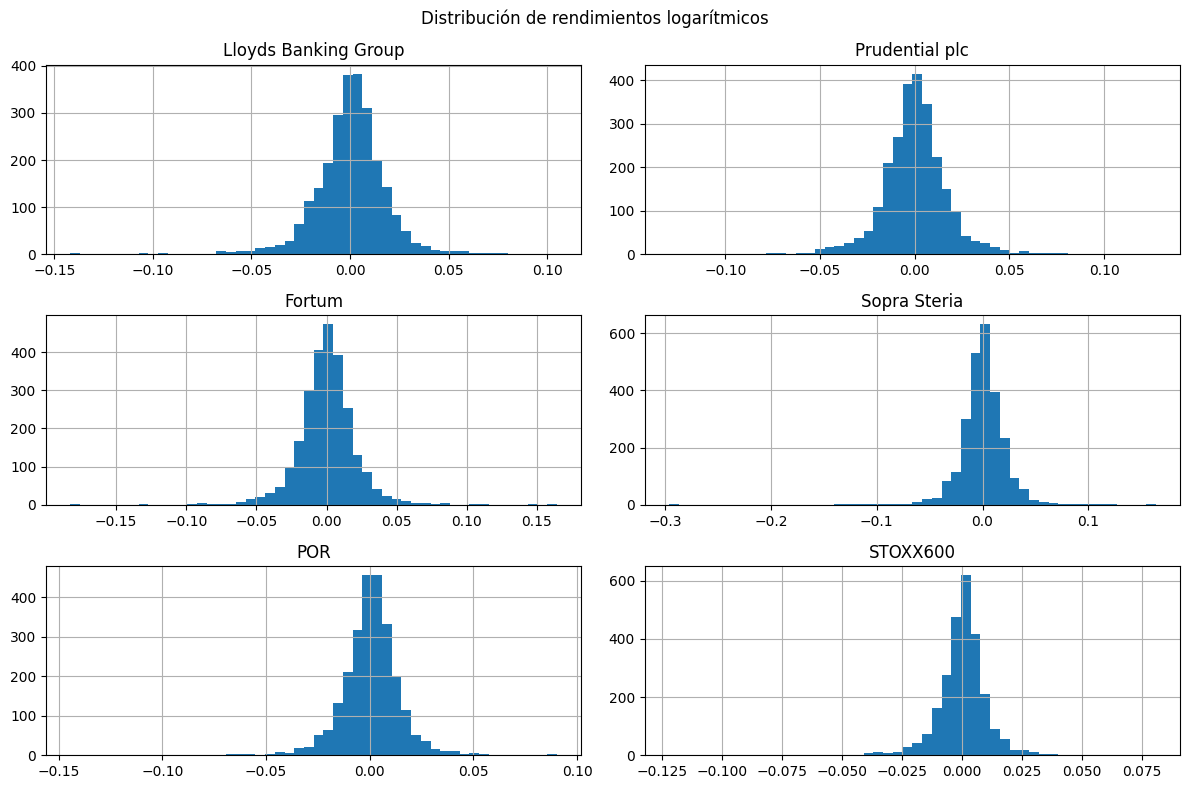

In [9]:
log_returns[series_for_analysis].hist(
    bins=50,
    figsize=(12, 8),
    layout=(3, 2)
)
plt.suptitle("Distribución de rendimientos logarítmicos")
plt.tight_layout()
plt.show()

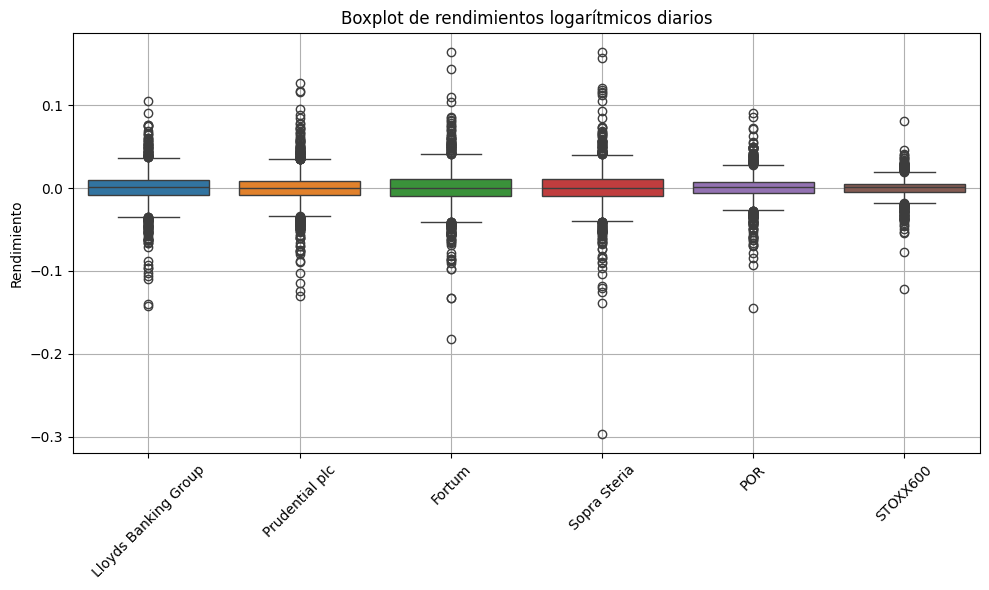

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=log_returns[series_for_analysis])
plt.title("Boxplot de rendimientos logarítmicos diarios")
plt.ylabel("Rendimiento")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

- Pregunta 3

In [11]:
IND = log_returns["STOXX600"]

firms = {
    "LLOY.L": "Lloyds Banking Group",
    "PRU.L": "Prudential plc",
    "FORTUM.HE": "Fortum",
    "SOP.PA": "Sopra Steria",
    "POR":"POR"
}

quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]


In [12]:
results_beta = pd.DataFrame(
    index=firms.keys(),
    columns=[str(q) for q in quantiles] + ["MCO"]
)

for firm_code, firm_name in firms.items():
    data = pd.concat([log_returns[firm_name], IND], axis=1).dropna()
    y = data[firm_name]
    X = sm.add_constant(data["STOXX600"])



    # Cuantílica
    for q in quantiles:
        model_qr = QuantReg(y, X).fit(q=q)
        results_beta.loc[firm_code, str(q)] = model_qr.params["STOXX600"]

    # MCO
    model_ols = sm.OLS(y, X).fit()
    results_beta.loc[firm_code, "MCO"] = model_ols.params["STOXX600"]

results_beta = results_beta.astype(float).round(4)

In [13]:
new_order = ["0.01", "0.05", "0.25", "0.5", "MCO", "0.75", "0.95", "0.99"]
results_beta = results_beta[new_order]

print("\nTABLA 1.- Regresión cuantílica\n")
print(results_beta)


TABLA 1.- Regresión cuantílica

             0.01    0.05    0.25     0.5     MCO    0.75    0.95    0.99
LLOY.L     1.0222  0.9750  0.9570  0.8921  0.9396  0.8853  0.9242  0.9855
PRU.L      1.6035  1.2398  1.0207  0.9985  1.1324  1.0435  1.3098  1.3955
FORTUM.HE  1.7006  1.5220  1.4240  1.3764  1.4669  1.3675  1.4715  1.6713
SOP.PA     1.0495  1.0537  1.0574  1.0694  1.0997  1.0964  1.0557  1.0324
POR        1.2530  1.2213  1.1458  1.0962  1.1596  1.1363  1.2091  1.1915


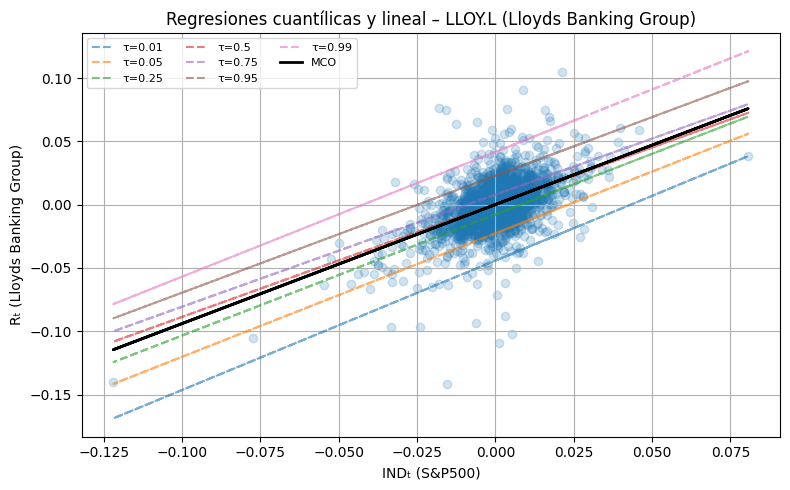

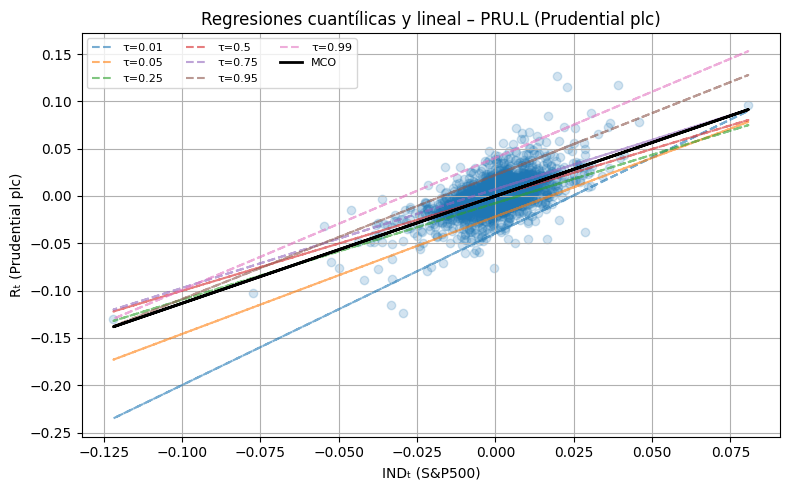

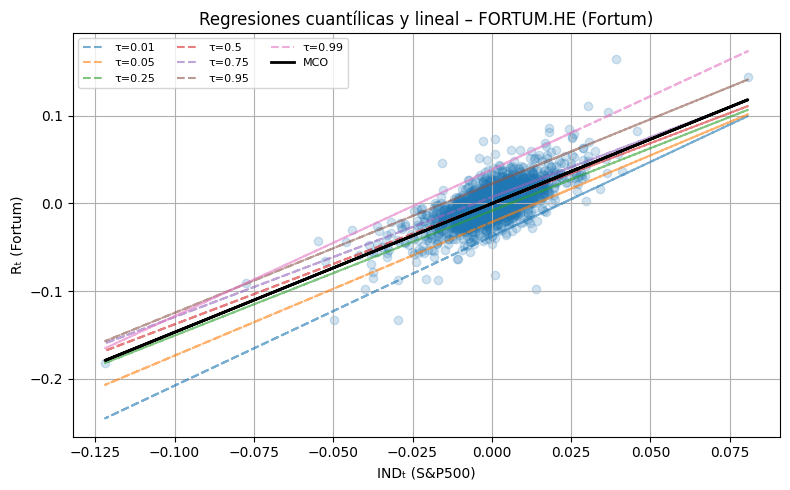

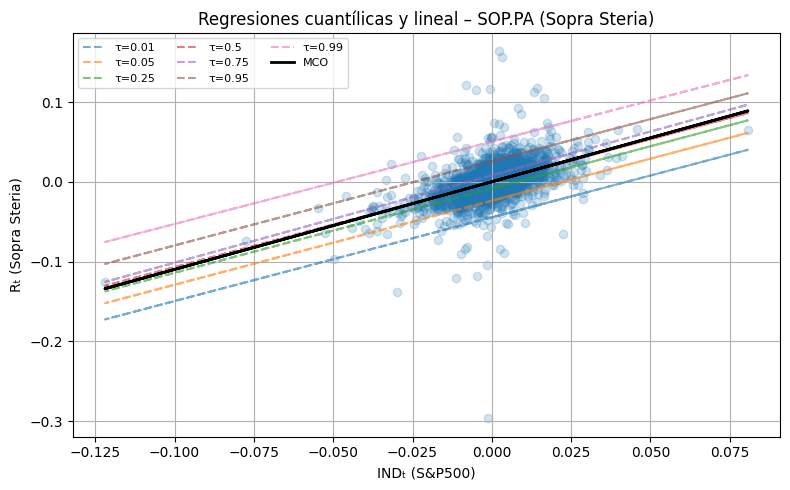

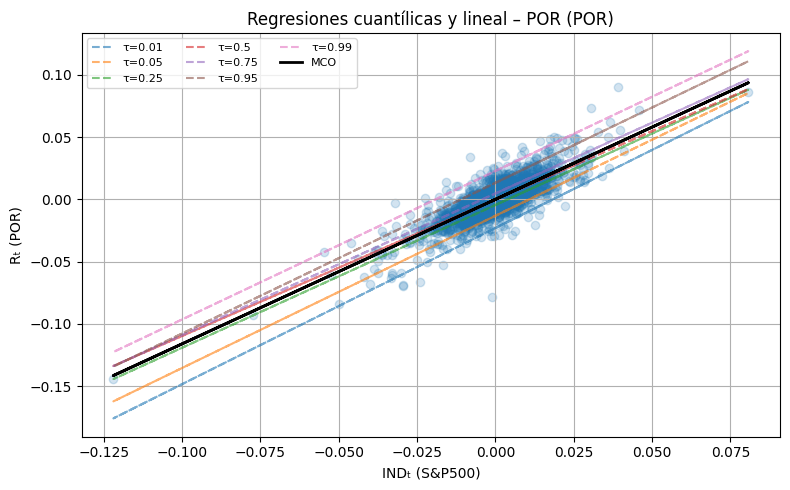

In [14]:
for firm_code, firm_name in firms.items():
    data = pd.concat([log_returns[firm_name], IND], axis=1).dropna()
    y = data[firm_name]
    X = sm.add_constant(data["STOXX600"])

    plt.figure(figsize=(8, 5))

    for q in quantiles:
        model_qr = QuantReg(y, X).fit(q=q)
        plt.plot(
            IND,
            model_qr.params["const"] + model_qr.params["STOXX600"] * IND,
            linestyle="--",
            alpha=0.6,
            label=f"τ={q}"
        )

    model_ols = sm.OLS(y, X).fit()
    plt.plot(
        IND,
        model_ols.params["const"] + model_ols.params["STOXX600"] * IND,
        color="black",
        linewidth=2,
        label="MCO"
    )

    plt.scatter(IND, y, alpha=0.2)
    plt.title(f"Regresiones cuantílicas y lineal – {firm_code} ({firm_name})")
    plt.xlabel("INDₜ (S&P500)")
    plt.ylabel(f"Rₜ ({firm_name})")
    plt.legend(ncol=3, fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- Pregunta 4

- 4.1

In [15]:
tau = 0.01
theta = 0.05

firms_codes = {
    "LLOY.L": "Lloyds Banking Group",
    "PRU.L": "Prudential plc",
    "FORTUM.HE": "Fortum",
    "SOP.PA": "Sopra Steria"
}

indexes = {
    "IND": "STOXX600",
    "POR": "POR"
}


In [16]:
VaR_CaViaR = {}
betas_caviar = {}

for code, name in firms_codes.items():
    VaR_CaViaR[code], betas_caviar[code] = caviar_asymmetric(
        log_returns[name], tau
    )
    print(f"{code} – betas CaViaR estimados:", np.round(betas_caviar[code], 4))

LLOY.L – betas CaViaR estimados: [-0.0025  0.8792  0.      0.5058]
PRU.L – betas CaViaR estimados: [-0.02  0.9   0.1   0.1 ]
FORTUM.HE – betas CaViaR estimados: [-0.0014  0.9679  0.0846  0.1375]
SOP.PA – betas CaViaR estimados: [-0.0014  0.9751  0.1002  0.1028]


In [17]:
VaR_param = {}

for code, name in firms_codes.items():
    VaR_param[code] = parametric_var_gjr(log_returns[name], tau)

VaR_param["IND"] = parametric_var_gjr(log_returns["STOXX600"], tau)
VaR_param["POR"] = parametric_var_gjr(log_returns["POR"], tau)

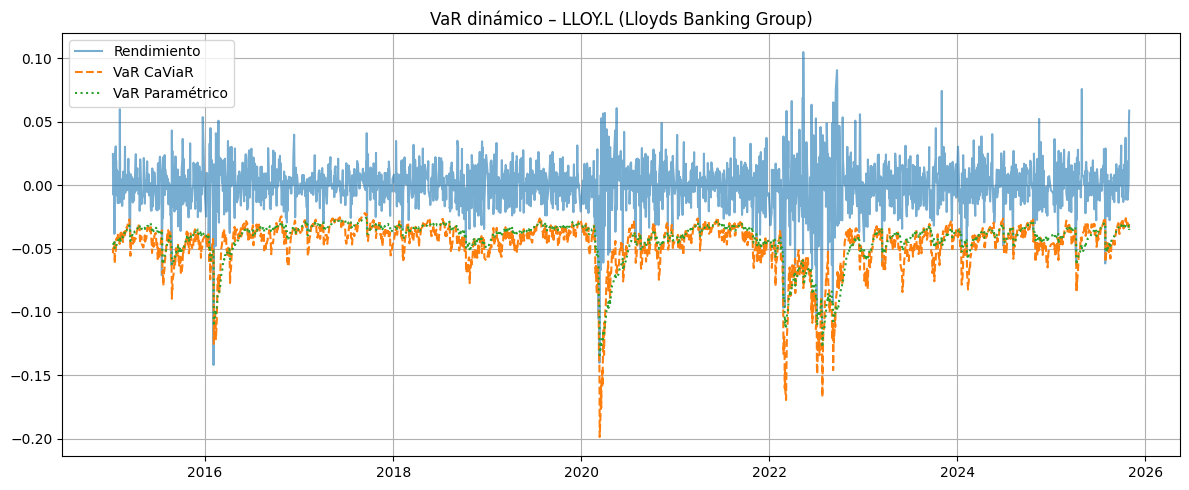

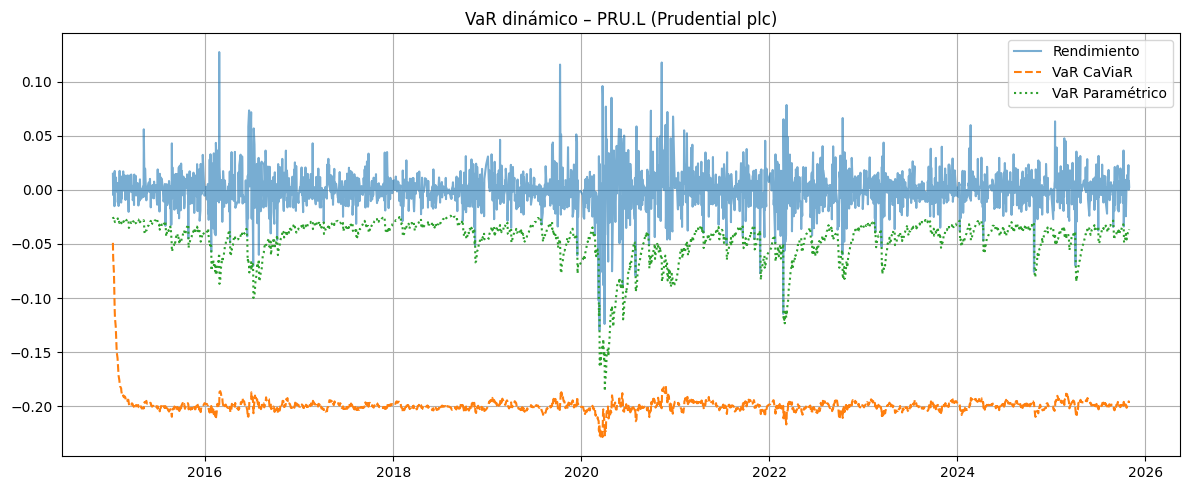

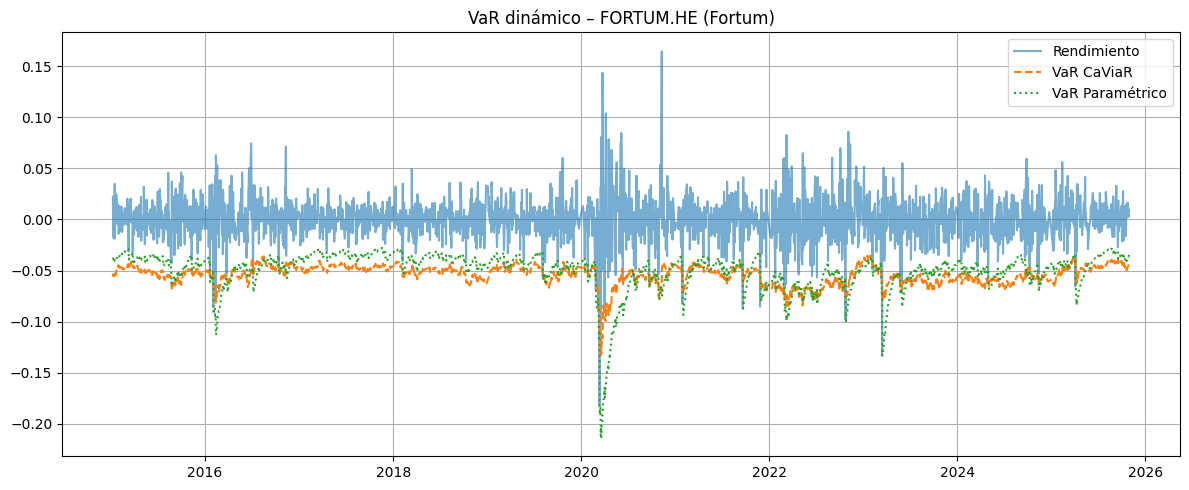

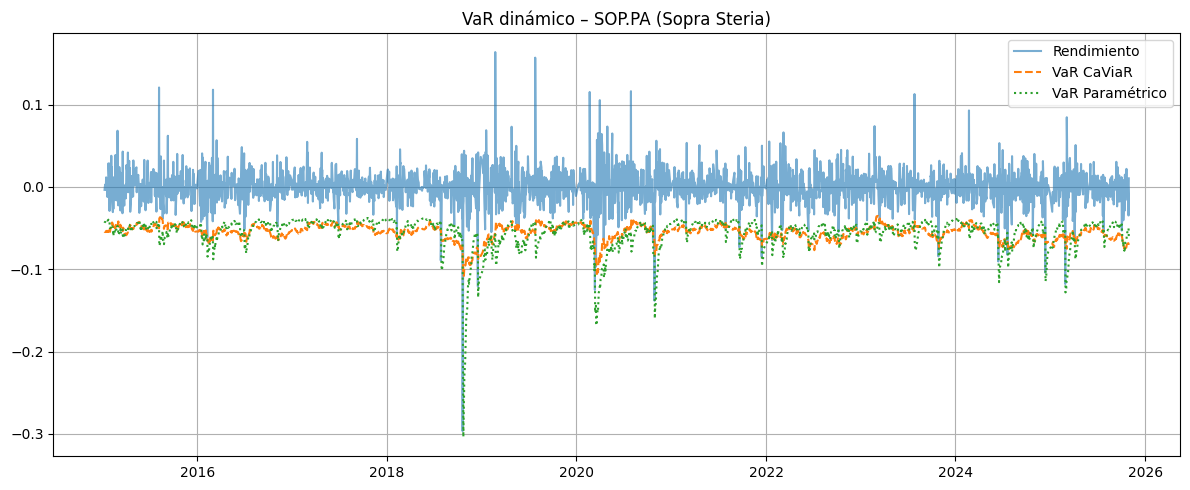

In [18]:
for code, name in firms_codes.items():
    plt.figure(figsize=(12,5))
    plt.plot(log_returns[name], label="Rendimiento", alpha=0.6)
    plt.plot(VaR_CaViaR[code], label="VaR CaViaR", linestyle="--")
    plt.plot(VaR_param[code], label="VaR Paramétrico", linestyle=":")
    plt.title(f"VaR dinámico – {code} ({name})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- 4.2

In [19]:
table_ind = []
table_por = []

for code, name in firms_codes.items():

    x = log_returns[name]
    y_ind = log_returns["STOXX600"]
    y_por = log_returns["POR"]

    df_ind = pd.concat([y_ind, x], axis=1).dropna()
    df_por = pd.concat([y_por, x], axis=1).dropna()

    X_ind = sm.add_constant(df_ind[name])
    X_por = sm.add_constant(df_por[name])

    qr_ind = QuantReg(df_ind["STOXX600"], X_ind).fit(q=tau)
    table_ind.append([
        code,
        qr_ind.params[0], qr_ind.bse[0], qr_ind.pvalues[0],   
        qr_ind.params[1], qr_ind.bse[1], qr_ind.pvalues[1],   
        qr_ind.prsquared
    ])

    qr_por = QuantReg(df_por["POR"], X_por).fit(q=tau)
    table_por.append([
        code,
        qr_por.params[0], qr_por.bse[0], qr_por.pvalues[0],
        qr_por.params[1], qr_por.bse[1], qr_por.pvalues[1],
        qr_por.prsquared
    ])

In [20]:
cols = [
    "Empresa",
    "β̂1", "dt(β̂1)", "p-value(β̂1)",
    "β̂2", "dt(β̂2)", "p-value(β̂2)",
    "Pseudo-R2"
]

tabla_IND = pd.DataFrame(table_ind, columns=cols)
tabla_POR = pd.DataFrame(table_por, columns=cols)

print("\nTABLA 3. Estimaciones regresión cuantílica – Correlaciones τ=0.01 (V.Dependiente: IND)\n")
print(tabla_IND.round(4))

print("\nTABLA 3. Estimaciones regresión cuantílica – Correlaciones τ=0.01 (V.Dependiente: POR)\n")
print(tabla_POR.round(4))


TABLA 3. Estimaciones regresión cuantílica – Correlaciones τ=0.01 (V.Dependiente: IND)

     Empresa     β̂1  dt(β̂1)  p-value(β̂1)     β̂2  dt(β̂2)  p-value(β̂2)  \
0     LLOY.L -0.0229   0.0009           0.0  0.3719   0.1503        0.0134   
1      PRU.L -0.0207   0.0008           0.0  0.4404   0.1334        0.0010   
2  FORTUM.HE -0.0188   0.0010           0.0  0.4198   0.1424        0.0032   
3     SOP.PA -0.0275   0.0024           0.0  0.2308   0.3691        0.5319   

   Pseudo-R2  
0     0.2787  
1     0.3657  
2     0.4055  
3     0.1810  

TABLA 3. Estimaciones regresión cuantílica – Correlaciones τ=0.01 (V.Dependiente: POR)

     Empresa     β̂1  dt(β̂1)  p-value(β̂1)     β̂2  dt(β̂2)  p-value(β̂2)  \
0     LLOY.L -0.0294   0.0019           0.0  0.6205   0.2690        0.0212   
1      PRU.L -0.0249   0.0013           0.0  0.7068   0.1949        0.0003   
2  FORTUM.HE -0.0232   0.0009           0.0  0.6637   0.1220        0.0000   
3     SOP.PA -0.0289   0.0023           0.0 

- 4.3

In [21]:
CoVaR = {"IND": {}, "POR": {}}

for code, name in firms_codes.items():

    x = log_returns[name]
    y_ind = log_returns["STOXX600"]
    y_por = log_returns["POR"]
    var_x = VaR_param[code]

    df_ind = pd.concat([y_ind, x, var_x], axis=1).dropna()
    df_por = pd.concat([y_por, x, var_x], axis=1).dropna()

    X_ind = sm.add_constant(df_ind[name])
    qr_ind = QuantReg(df_ind["STOXX600"], X_ind).fit(q=tau)
    CoVaR["IND"][code] = (
        qr_ind.params[0] + qr_ind.params[1] * df_ind[var_x.name]
    )

    X_por = sm.add_constant(df_por[name])
    qr_por = QuantReg(df_por["POR"], X_por).fit(q=tau)
    CoVaR["POR"][code] = (
        qr_por.params[0] + qr_por.params[1] * df_por[var_x.name]
    )

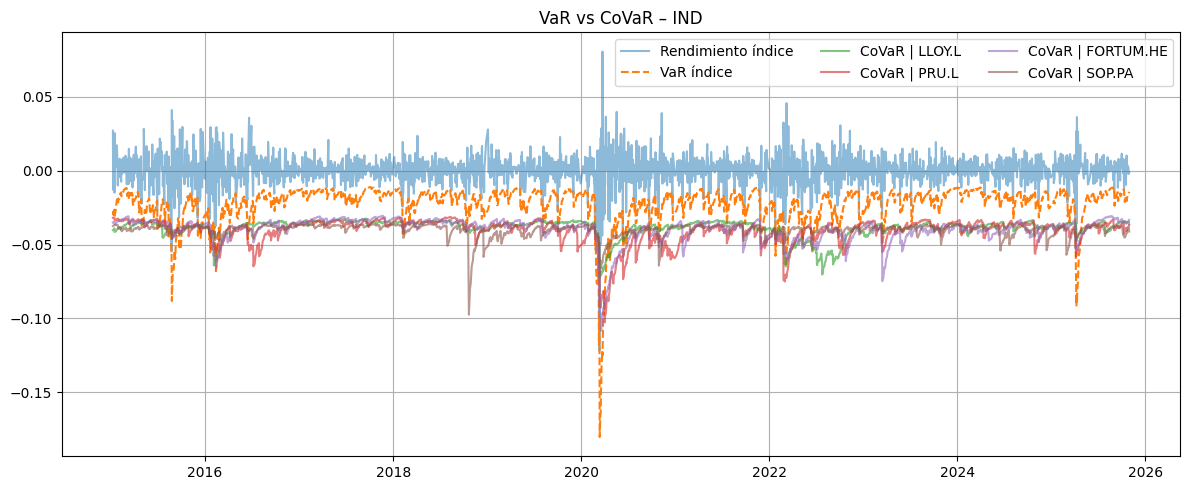

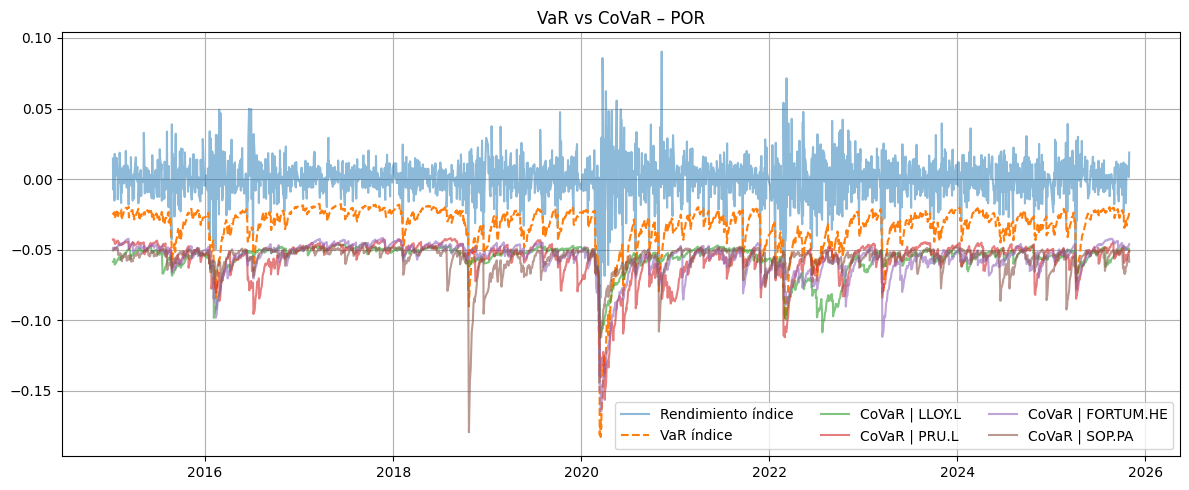

In [22]:
for idx in ["IND", "POR"]:
    plt.figure(figsize=(12,5))
    plt.plot(log_returns["STOXX600"] if idx=="IND" else log_returns["POR"],
             label="Rendimiento índice", alpha=0.5)
    plt.plot(VaR_param[idx], label="VaR índice", linestyle="--")

    for code in firms_codes:
        plt.plot(CoVaR[idx][code], alpha=0.6, label=f"CoVaR | {code}")

    plt.title(f"VaR vs CoVaR – {idx}")
    plt.legend(ncol=3)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- 4.4

In [23]:
Delta_CoVaR = {"IND": {}, "POR": {}}

for idx in ["IND", "POR"]:
    for code, name in firms_codes.items():
        covar_stress = CoVaR[idx][code]
        x = log_returns[name]
        y = log_returns["STOXX600"] if idx == "IND" else log_returns["POR"]
        df = pd.concat([y, x], axis=1).dropna()

        X_med = sm.add_constant(df[name])

        qr_med = QuantReg(df[y.name], X_med).fit(q=0.5)

        CoVaR_med = (
            qr_med.params[0]
            + qr_med.params[1] * df[name]
        )

        Delta_CoVaR[idx][code] = (
            covar_stress.loc[df.index] - CoVaR_med
        )

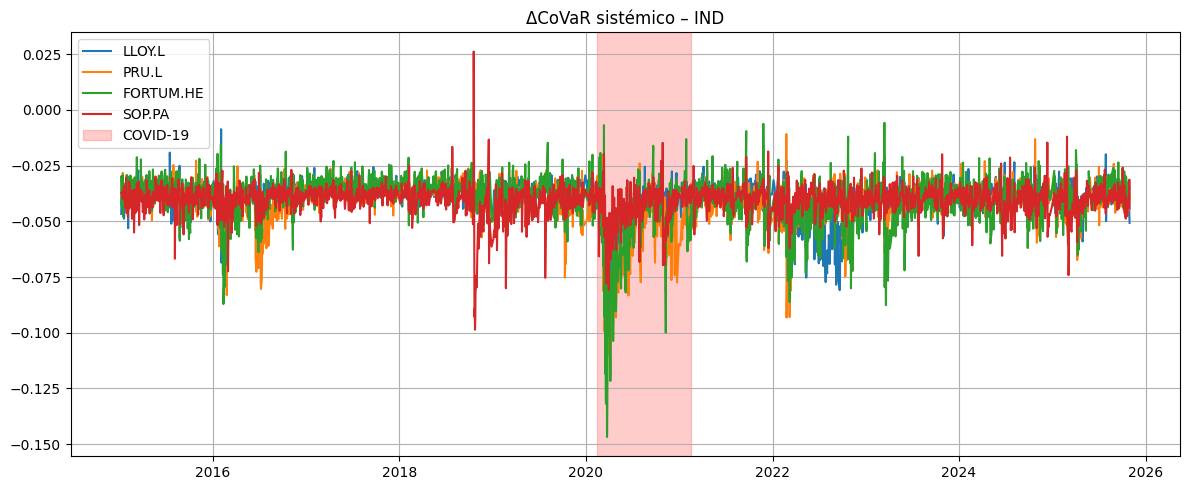

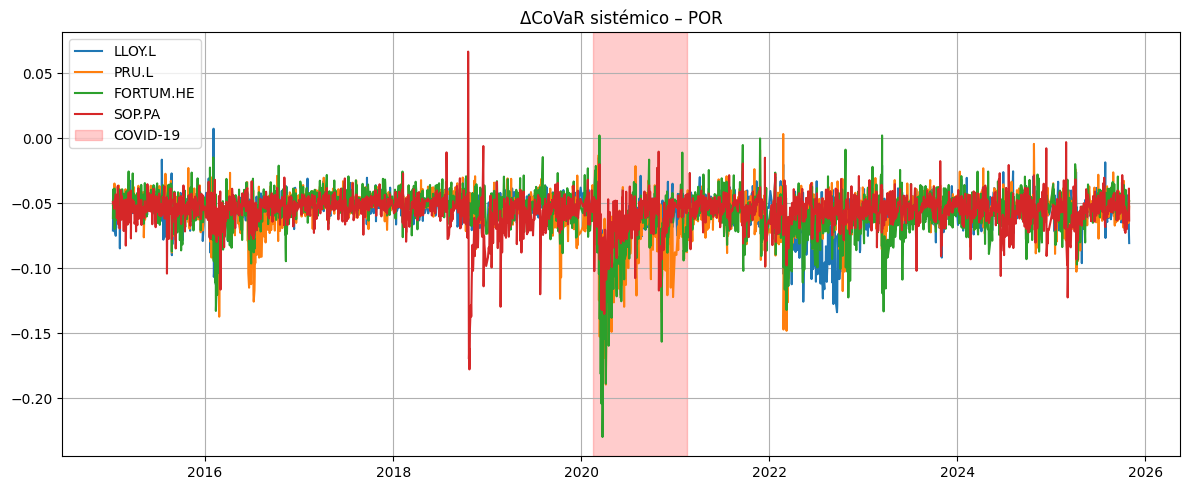

In [24]:
covid_start = "2020-02-15"
covid_end = "2021-02-15"

for idx in ["IND", "POR"]:
    plt.figure(figsize=(12,5))

    for code in firms_codes:
        plt.plot(Delta_CoVaR[idx][code], label=code)

    plt.axvspan(covid_start, covid_end, color="red", alpha=0.2, label="COVID-19")
    plt.title(f"ΔCoVaR sistémico – {idx}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
desc_IND_total = clean_desc(
    {k: v for k, v in Delta_CoVaR["IND"].items()},
    "IND (Total)"
)

desc_POR_total = clean_desc(
    {k: v for k, v in Delta_CoVaR["POR"].items()},
    "POR (Total)"
)


DESCRIPTIVOS ΔCoVaR – IND (Total)

           Media  Mediana  Desv. típica
Empresa                                
LLOY.L    -0.039   -0.038         0.008
PRU.L     -0.041   -0.039         0.010
FORTUM.HE -0.040   -0.039         0.011
SOP.PA    -0.041   -0.040         0.007

DESCRIPTIVOS ΔCoVaR – POR (Total)

           Media  Mediana  Desv. típica
Empresa                                
LLOY.L    -0.057   -0.054         0.014
PRU.L     -0.057   -0.054         0.017
FORTUM.HE -0.057   -0.054         0.018
SOP.PA    -0.057   -0.054         0.014


In [26]:
desc_IND_covid = clean_desc(
    {k: v.loc["2020-02-15":"2021-02-15"] for k, v in Delta_CoVaR["IND"].items()},
    "IND (COVID)"
)

desc_POR_covid = clean_desc(
    {k: v.loc["2020-02-15":"2021-02-15"] for k, v in Delta_CoVaR["POR"].items()},
    "POR (COVID)"
)


DESCRIPTIVOS ΔCoVaR – IND (COVID)

           Media  Mediana  Desv. típica
Empresa                                
LLOY.L    -0.044   -0.041         0.011
PRU.L     -0.056   -0.052         0.017
FORTUM.HE -0.052   -0.046         0.021
SOP.PA    -0.044   -0.042         0.010

DESCRIPTIVOS ΔCoVaR – POR (COVID)

           Media  Mediana  Desv. típica
Empresa                                
LLOY.L    -0.064   -0.059         0.019
PRU.L     -0.081   -0.075         0.030
FORTUM.HE -0.075   -0.065         0.034
SOP.PA    -0.063   -0.059         0.019
